In [12]:
%logstop
%logstart -rtq ~/.logs/ML_Tree_Based_Models.py append
import seaborn as sns
sns.set()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Decision Trees and Tree Based Models

Decision trees are a general class of machine learning models that are used for both classification and regression. They have even been adapted for the use of outlier detection. The trained models resemble a tree, complete with branches and nodes. The model is essentially a series of questions with yes or no answers, where the resulting tree structure contains all the combination of responses.

Tree based models are popular because they mimic human decision making process, work well for a large class of problems, naturally handle multiclassification, and handle a mix of categorical and numerical data. They are also easy to understand and explain. The transparency of a model is often called its *explicability*. Models with low explicability are often referred to as "black boxes" and are difficult to derive insight over the process they are modeling.

In this notebook, we will discuss the decision tree model and understand how they are trained and used to make predictions. Further, we will analyze several advanced machine learning models that use decision trees as a building block to create models with greater predictive power.

## Training decision tree classifiers

The best way to understand a decision tree is to construct one and visualize it. We'll train a decision tree classifier on the iris data set and visualize the tree with the `Graphviz` package. The iris data set is a famous data set of 150 observations of three different iris species: setosa, versicolor, and virginica. Each observation has measurements of the petal length and width and sepal length and width, for a total of four features.

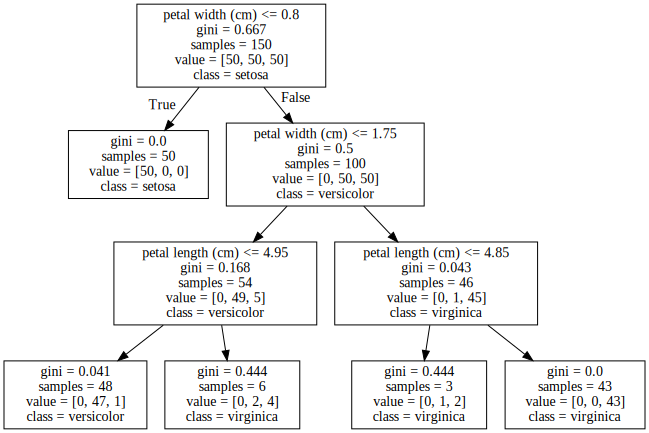

In [4]:
import graphviz
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# load data set
data = load_iris()
X = data['data']
y = data['target']

# train decision tree
tree = DecisionTreeClassifier(max_depth=3,)
tree.fit(X, y)

# visual tree
graphviz.Source(export_graphviz(tree, 
                                out_file=None,
                                feature_names=data['feature_names'],
                                class_names=data['target_names']))

Note how the model resembles an upside down tree and each box represents a node in the tree. Printed in each box is

* **samples**: the number of observations in the node.
* **Gini**: a measure of node purity.
* **value**: the distribution of observations in each class.
* **class**: the most common label in the node.

At the top of the tree is the __root node__. This node is _split_ to form two branches. Observations that satisfy the criterion printed at the top of the box are moved to one branch while the rest to the other. You can view a decision tree as a model that is making partitions in a space that contains your training data. For classification, the partitions are chosen to separate the different classes while in regression, the partitions are picked to reduce the variance of sample labels. For the tree displayed above, node splits were chosen to lead to an overall reduction of the Gini metric, discussed further in the next section. The nodes that do not branch off are called __terminal nodes__ or __leaves__.

With a trained tree, predictions are made on an observation by starting at the root and following the path as a result of the criterion in each node. Once at a leaf, the predicted class is the class with the plurality. For example, if an observation has a petal length of 2.5 cm and a petal width of 1 cm, it will reside in the left most leaf in the figure. Since there were 47 training observations of class versicolor and 1 of virginica that resided in the leaf, any observation landing in this leaf will be predicted as versicolor.

Our trained tree model only makes splits using two features, the petal length and width, making it easy to visualize our model. The interactive figure below lets you control the splitting process described above for the iris data set. 

In [5]:
from ipywidgets import interact, IntSlider

def iris_tree(depth=1):
    plt.scatter(X[:, 2], X[:, 3], c=y, cmap=plt.cm.viridis)
    
    if depth >= 1:
        plt.hlines(0.8, 0.8, 7, linewidth=2)
    if depth >= 2:
        plt.hlines(1.75, 0.8, 7, linewidth=2)
    if depth >= 3:
        plt.vlines(4.85, 1.75, 2.6, linewidth=2)
        plt.vlines(4.95, 0.8, 1.74, linewidth=2)

    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.xlim([0.8, 7])
    plt.ylim([0, 2.6])
    
depth_slider = IntSlider(value=0, min=0, max=3, step=1, description='depth')
interact(iris_tree, depth=depth_slider);

interactive(children=(IntSlider(value=0, description='depth', max=3), Output()), _dom_classes=('widget-interac…

### Gini impurity

For classification, decision trees use the Gini impurity metric, a measure of node impurity. The Gini impurity is equal to the probability of misclassifying an observation if it were randomly labeled based on the distribution of labels of the node. The decision tree will perform node splits that result in reducing the Gini metric. The equation for the Gini impurity for node $m$ is

$$ G_m = \sum_k p_{mk} (1 - p_{mk}), $$

where $p_{mk}$ is the fraction of observations of class $k$ in node $m$. Consider two cases where a node has 10 observations belonging to two classes. In the first case, each class has equal representation in the node, [5, 5]. In the second, only the first class is present, [10, 0]. The Gini impurity for both cases are

* Case 1: [5, 5]
$$ G = \frac{5}{10} \left(1 - \frac{5}{10}\right) + \frac{5}{10} \left(1 - \frac{5}{10}\right) = 0.5 $$
* Case 2: [10, 0]
$$ G = \frac{10}{10} \left(1 - \frac{10}{10}\right) + \frac{0}{10} \left(1 - \frac{0}{10}\right) = 0 $$

The greater the node purity, the lower the Gini metric. See the plot below of how Gini varies with $p_{mk}$ when there are two classes.

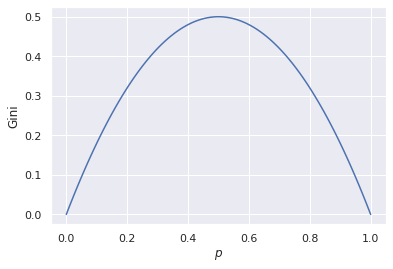

In [6]:
p = np.linspace(1E-6, 1-1E-6, 100)
gini = p*(1-p) + (1-p)*p

plt.plot(p, gini)
plt.xlabel('$p$')
plt.ylabel('Gini');

### Entropy

In chemistry, entropy is a measure of the number of microstates of a system and can be viewed as the amount of disorder. The concept of entropy is useful in other fields such as information theory where entropy is a measure of the amount of missing information. The more information is missing, the more uncertainty exists in a process. The equation for entropy of node $m$ is

$$ H_m = -\sum_{k} p_{mk} \log_2(p_{mk}).$$

Using the same two cases as before when calculating the Gini metric, the entropy is equal to

* Case 1: [5, 5]
$$ H = -\left[\frac{5}{10} \log_2 \left(\frac{5}{10}\right) + \frac{5}{10} \log_2 \left(\frac{5}{10}\right)\right] = 1  $$
* Case 2: [10, 0]
$$ H = -\left[\frac{10}{10} \log_2 \left(\frac{10}{10}\right) + \frac{0}{10} \log_2 \left(\frac{0}{10}\right)\right] = 0 $$

Similar to the Gini impurity, a more pure node will have lower entropy. Since entropy and Gini impurity are very similar metrics, using either will not make any substantial difference in your classifier. By default, the `DecisionTreeClassifier` class uses the Gini metric but can be switched to entropy by setting `criterion='entropy'`.

## Constructing decision trees for regression

The process of constructing a decision tree for regression is the nearly identical as classification. However, instead performing node splits that result in an overall drop of entropy or Gini impurity, splits are chosen to produce nodes with an overall reduction in variance of the training labels. Mathematically,

$$ \Delta V = \left(\frac{n_L}{n_L + n_R}\right)\sigma^2_L + \left(\frac{n_R}{n_L + n_R}\right)\sigma^2_R,$$

where $n$ and $\sigma^2$ is the number of nodes and variance in the left $L$ and right $R$ nodes from the split, respectively. For making predictions, once an appropriate leaf has been identified for an observation, the predicted label value is the mean of all training samples that resided in the leaf. Below, we illustrate the trained tree with the California housing data.

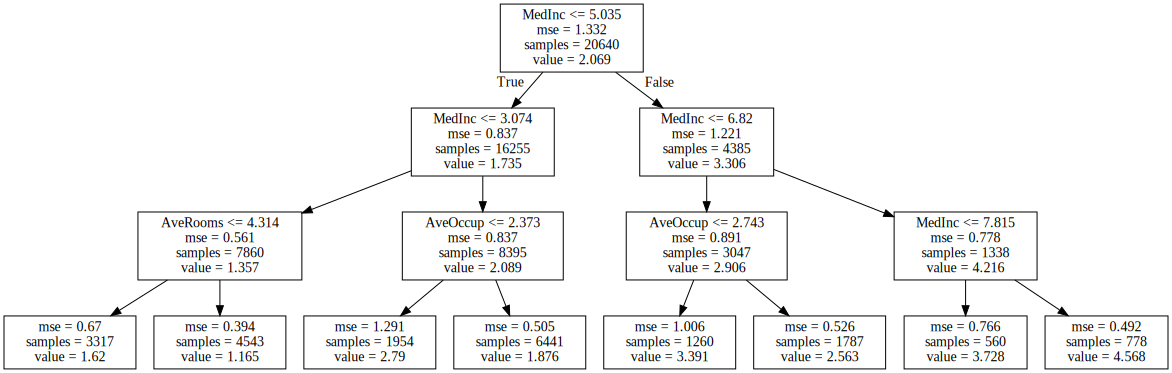

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor

# load data set
data = fetch_california_housing()
X = data['data']
y = data['target']

# train decision tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

# visual tree
graphviz.Source(export_graphviz(tree, 
                                out_file=None,
                                feature_names=data['feature_names']))

The box have entries of "mse" and "value" with the following meanings:

* **mse**: mean squared error using the mean label value for the predictions, equal to the label variance of the node
* **value**: the mean label value of all observations in the node

The variance, equal to the mean squared error, of a child node _may_ be greater than the parent node but the overall weighted variance as a result of the split is lower.

## Tree training algorithm

There are several algorithms available to determine node splits in decision trees. `scikit-learn` uses the   Classification And Regression Tree (CART) algorithm. The steps in the algorithm are

1. For each feature $p$, construct _thresholds_ $t_{pi}$. An example of a threshold for a feature is petal width $\leq$ 0.8 cm.
1. Choose the threshold that results in the greatest reduction of the _weighted_ error metric. For example, using the criterion petal width $\leq$ 0.8 cm leads to the greatest drop in overall Gini impurity from the resulting two new nodes.
1. Split the data set into two sets, nodes, using the chosen threshold.
1. Repeat the process on the _child_ nodes until a termination criterion is met.

The node splitting process is _greedy_, the model chooses the split point that will result in the greatest reduction of the loss metric at the moment. Greedy algorithms are those that make the locally optimal choice. They do not consider making suboptimal choices that may setup an overall better choice in later iterations. Greedy algorithms may not always converge to the global minimum but will often have better time complexities than algorithms that may result in a more optimal solution. The choice of a greedy algorithm for decision trees is an example of trading some model performance, ideally a small amount, for a gain in faster computation.

## Decision Tree Hyperparameters

As you have seen before, the `max_depth` is a key hyperparameter for decision trees. It controls how deep the tree is allowed to grow, thus, how adaptive the model is to fit the training data. As the depth gets greater, the model gets more complex, and has a higher propensity for large variance error. The `max_depth` isn't the only hyperparameter you can tune; several others are

<table>
    <tr>
        <th style="text-align: left">Hyperparameter</th>
        <th style="text-align: left">Description</th>
    </tr>    
    <tr>
        <td style="text-align: left"><code>max_depth</code></td>
        <td style="text-align: left">The maximum depth of the tree </td>
	</tr>
    <tr>
        <td style="text-align: left"><code>max_features</code></td>
        <td style="text-align: left">The number of features to consider when deciding the best split</td>
	</tr>
	<tr>
        <td style="text-align: left"><code>min_samples_split</code></td>
        <td style="text-align: left">Minimum number of samples required to consider a split on an internal node</td>
	</tr>
	<tr>
        <td style="text-align: left"><code>min_samples_leaf</code></td>
        <td style="text-align: left">Minimum number of samples required for a leaf (terminal node)</td>
	</tr>
</table>

As with any machine learning model, it is important to understand how the hyperparameters controls the model's bias and variance error. The best way to analyze a hyperparameter's affect on a model is to consider whether it increases or decreases the model's ability to adapt to the training data. As always, `scikit-learn` has extensive documentation that details all of the hyperparameters available and their meaning.

**Question**
* For each hyperparameter, how does it affect a model's bias and variance error?

## Geometric interpretation

It sometimes helps to visualize how our model is making decision through the use of a decision boundary. We'll train a decision tree classifier using a data set with two features.

In [8]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=250, noise=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def tree_decision_boundary(X_train, X_test, y_train, y_test):
    def plotter(max_depth=5, min_samples_leaf=2):
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        tree.fit(X_train, y_train)
        accuracy = tree.score(X_test, y_test)
    
        X1, X2 = np.meshgrid(np.linspace(-2, 3), np.linspace(-2, 2))
        y_proba = tree.predict_proba(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))[:, 1]
        plt.contourf(X1, X2, y_proba.reshape(50, 50),  16, cmap=plt.cm.bwr, alpha=0.75)
        plt.colorbar()

        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='white', cmap=plt.cm.bwr)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.title('accuracy: {}'.format(accuracy));

    return plotter

depth_slider = IntSlider(min=1, max=40, step=1, description='max depth')
min_samples_leaf_slider = IntSlider(min=1, max=20, step=1, description='min leaf size')
interact(tree_decision_boundary(X_train, X_test, y_train, y_test),
         max_depth=depth_slider,
         min_samples_leaf=min_samples_leaf_slider);

interactive(children=(IntSlider(value=1, description='max depth', max=40, min=1), IntSlider(value=1, descripti…

In the figure, we see how the model is creating partitions in our feature space, attempting to box in the observations belonging to the same class. The partitions are perpendicular to an axis. Because of the perpendicular partitions, decision trees work best when the features are not strongly correlated. A technique like principal component analysis that generate linearly uncorrelated features help out decision tree models.

**Question**
* For decision trees, there is no need to scale your data. Why is this?

## Training and predicting time complexities

An important consideration when choosing a machine learning model is the time complexity for training and making predictions. Consider a balanced tree where the number of nodes and branches at every level/depth of the tree is equal. At most, the depth of the tree will be $\log(n)$ since the number of nodes is equal to $2^d$. For the CART algorithm, at each depth, we must evaluate $np$ possible cut points. Overall, the time complexity for training is $O(np\log(n))$.

Making a prediction involves traversing the tree from root to terminal node. Once again assuming a balanced tree, the model will make $\log(n)$ decisions to arrive at a leaf. The predicting time complexity is simply $O(\log(n))$. In general, making predictions using decision trees is faster than training.

## Ensemble models

Ensemble models are machine learning models that use more than one predictor to arrive at a prediction. A group of predictors form an _ensemble_. In general, ensemble models perform better than using a single predictor. There are three types of ensemble models, bagging, boosting, and blending. Of the three, decision trees have been used to construct bagging and boosting based models.

### Random forests

The performance of a single decision tree will be limited. Instead of relying on one tree, a better approach is to aggregate the predictions of multiple tree. On average, aggregation will perform better than a single predictor. You can envision the aggregation as mimicking the idea of "wisdom of the crowd". We call a tree based model that aggregates the predictions of multiple trees a __random forest__.

In order for a random forest to be effective, the model needs a diverse collection of trees. There should be variations in the chosen thresholds for splitting and the number of nodes and branches. There is no point in aggregating the predicted results if all the trees are nearly identical and produce the same result. There is no "wisdom of the crowd" if everyone thinks alike. To achieve a diverse set of trees, we need to:

1. Train each tree in the forest using a different training set.
1. Only consider a subset of features when deciding how to split the nodes.

For the first point, ideally we would generate a new training set for each tree. However, often times it's too difficult or expensive to collect more data; we have to make due with what we have. Bootstrapping is a general statistical technique to generate "new" data sets with a single set by random sampling with _replacement_. Sampling with replacement allows for a data point to be sampled more than once.

Typically, when training the standard decision tree model, the algorithm will consider all features in deciding the node split. Considering only a subset of your features ensures that your trees do not resemble each other. If the algorithm had considered all features, a dominant feature would be continuously chosen for node splits.

The hyperparameters available for random forests include those of decision tress with some additions.

<table>
<tr>
<th style="text-align: left">Hyperparameter</th>
<th style="text-align: left">Description</th>
</tr>
    
<tr>
<td style="text-align: left"><code>n_estimators</code></td>
<td style="text-align: left">The number of trees in the forest</td>
</tr>

<tr>
<td style="text-align: left"><code>n_jobs</code></td>
<td style="text-align: left">The number of jobs to run in parallel when fitting and predicting</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>warm_start</code></td>
<td style="text-align: left">If set to <code>True</code>, reuse the trained tree from a prior fitting and just train the additional trees</td>
</tr>
</table>

Since the random forest is based on idea of bootstrapping and aggregating the results, it is referred to as a *bagging* ensemble model.

**Question**
* Are there any other advantages of considering a subset of the features?

Let's construct a plot of the test set error as a function of the size of the forest.

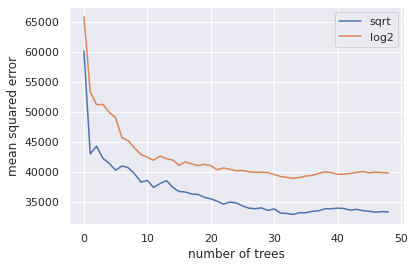

In [9]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=1000, n_features=100, n_informative=20, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def rf_mse(max_features='sqrt', n_max=50):
    """Generate mean squared errors for growing random forest."""
    
    rgr = RandomForestRegressor(max_features=max_features,
                                max_depth=8, n_estimators=1, 
                                warm_start=True, 
                                random_state=0)
    mse = np.zeros(n_max)

    for n in range(1, n_max):
        rgr.set_params(n_estimators=n)
        rgr.fit(X_train, y_train)
        mse[n-1] = mean_squared_error(y_test, rgr.predict(X_test))

    return mse

for param in ('sqrt', 'log2'):
    mse = rf_mse(max_features=param)
    plt.plot(mse[:-1])

plt.xlabel('number of trees')
plt.ylabel('mean squared error')
plt.legend(['sqrt', 'log2', 'all']);

There are several takeaways from the results plotted above.

1. There is sharp drop in error when initially growing the forest.
1. In general, as the number trees increase, performance increases.
1. You _can_ overfit with a large number of trees but the model is robust to overfitting with the number of trees
1. Note, the model was not tuned for hyperparameters like `max_depth` and `min_samples_split`.

The initial drop in error can be attributed to a large increase in diverse trees when the forest is small. In other words, the additional trees will be very different from the current trees simply because the forest is small. The increase in tree diversity drives predictive power. As the forest grows, newer trees will not be significantly different from the current pool of trees as bootstrapping is no longer producing substantially diverse training sets to create very different looking trees.

### Extremely Randomized Trees

An extremely randomized trees is a variation of the random forest model that injects additional randomness. As with a random forest, a random subset of the features are selected to determine which one to use for a node split. However, instead of considering the optimal split point _for each_ selected feature, a candidate for the split for each feature is chosen at _random_. From these randomly chosen values, the best is chosen to perform the split. The extra randomness serves two folds: it helps reduce the model's variance and leads to faster training times. In `scikit-learn`, the extremely randomized tree model is provided by `ensemble.ExtraTreesClassifier` and `ensemble.ExtraTreesRegressor`.

**Question**
* Can you formulate the training time complexity for both random forests and extremely randomized trees?

### Gradient Boosting Trees

Gradient boosting trees are another ensemble model; it is collection of tree models arranged in a sequence. Here, the model is built stage-wise; each additional tree aims to correct the previously built model's predictions. A model with $M$ trees is equal to 

$$ f_M(x_j) =  \sum^M_m \gamma_m h_m(x_j), $$

where $h_m$ is a **weak learner** decision tree, a "stump" model with low depth that performs poorly on its own. The term **boosting** refers to the algorithm's ability to combine multiple weak learners to form a strong learner. $\gamma_m$ is a factor that scales the contribution of a tree to the overall model. How are $h_m$ and $\gamma_m$ chosen? The model is usually initialized with $h_0$ being equal to the mean of the training labels for regression or the majority class for classification. We also need to choose a loss function $L(y, f_m)$. For example, if the loss function is squared error, then

$$ L_{SE}(y_j, f_m(x_j)) = (y_j-f_m(x_j))^2. $$ 

The steps for building our model with $M$ trees at each stage is

1. Compute the **pseudo-residuals**, the derivative of the loss function with respect to the previous model $f_{m-1}$. The equation for the pseudo-residuals for a model at stage $m$ is
$$ r_{jm} = - \left[\frac{\partial L(y_j, f(x_j))}{\partial f} \right]_{f(x_j) = f_{m-1}(x_j)}. $$
1. Train $h_m$ on the **pseudo-residuals** $r_{jm}$.
1. Choose $\gamma_m$ that minimizes $L(y_j, f_{m-1}(x_j) + \gamma_m h_m(x_j)).$
1. Form the improved model equal to
$$ f_m(x_j) = f_{m-1}(x_j) + \gamma_m h_m(x_j). $$
1. Repeat until the model includes all $M$ trees.

Where does the name gradient come from in gradient boosting trees? Adding a model is analogous to a single iteration in gradient descent. Gradient descent is a minimization algorithm that updates/improves the current answer by taking a step in the direction of the negative of the gradient of the function that is being minimized. The pseudo-residuals represent the direction of greatest reduction in prediction error. Since $h_m$ is trained on the direction of greatest descent of the loss, it will be an approximation of the improvement required for our model to fit the data more closely. $\gamma_m$ is the step size we should take in the direction of greatest model improvement. Compare the equation above for an improved model with the equation of gradient descent applied to a function $C(\beta_i)$;

$$\beta^{updated}_i = \beta^{current}_i - \gamma \left(\left.\frac{\partial C}{\partial \beta_i}\right)\right|_{\beta_i=\beta^{current}_i}.$$

The concept of pseudo-residuals allows us to generalize gradient boosting trees for any loss function. In fact, when we use a square loss function like the squared error, the pseudo-residual is directly proportional to the residual, $y_j - f(x_j)$

Gradient boosting trees have a similar set of hyperparameters as random forests but with some key additions.

<table>
	<tr>
    <th style="text-align: left">Hyperparameter</th>
    <th style="text-align: left">Description</th>
	</tr>  
    <tr>
        <td style="text-align: left"><code>learning_rate</code></td>
        <td style="text-align: left">Multiplicative factor of the tree's contribution to the model.</td>
	</tr>
    <tr>
        <td style="text-align: left"><code>subsample</code></td>
        <td style="text-align: left">Fraction of the training data to use when fitting the trees.</td>
	</tr>
</table>

The learning rate ranges form 0 to 1, with the modified equation being

$$ f_m(x_j) = f_{m-1}(x_j) + \nu \gamma_m h_m(x_j), $$

where $\nu$ is the learning rate. The learning rate and subsampling fraction interact with each other, we will see this in the figure below.

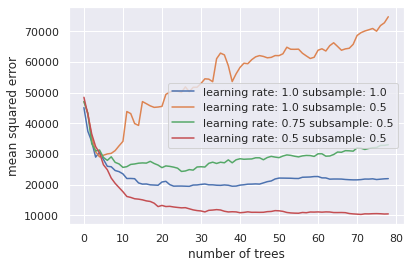

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

def gb_mse(learning_rate=1.0, subsample=1.0, n_max=80):
    """Generate mean squared errors for growing gradient boosting trees."""
    
    rgr = GradientBoostingRegressor(learning_rate=learning_rate,
                                    subsample=subsample,
                                    max_depth=2, 
                                    n_estimators=1, 
                                    warm_start=True, 
                                    random_state=0)
    mse = np.zeros(n_max)

    for n in range(1, n_max):
        rgr.set_params(n_estimators=n)
        rgr.fit(X_train, y_train)
        mse[n-1] = mean_squared_error(y_test, rgr.predict(X_test))

    return mse

def gen_legend_str(hparams):
    """Generate strings for legend in plot."""
    
    base_str = 'learning rate: {} subsample: {}'
    
    return [base_str.format(d['learning_rate'], d['subsample']) for d in hparams]

hparams = ({'learning_rate': 1.0, 'subsample': 1.0},
           {'learning_rate': 1.0, 'subsample': 0.5},
           {'learning_rate': 0.75, 'subsample': 0.5},
           {'learning_rate': 0.5, 'subsample': 0.5})

for kwargs in hparams:
    mse = gb_mse(**kwargs)
    plt.plot(mse[:-1])

legend_strs = gen_legend_str(hparams)
plt.xlabel('number of trees')
plt.ylabel('mean squared error')
plt.legend(legend_strs);

The plot above has the same characteristics as that of random forests. In general:

1. If you apply subsampling, you need to lower the learning rate.
1. Decreasing the learning rate requires more trees.

As with gradient descent, at some point, additional iterations result in negligible model improvement as the algorithm has converged.

**Question**
* If you have a model with high variance error, how should you modify the values of the subsampling fraction and learning rate to reduce variance?

## Feature importance

Decision trees have the capability to evaluate feature importance. The feature importance score is based on two metrics:

* How many times a particularly feature was selected to split a node
* The depth where the feature was selected to split the node

If a feature is chosen numerous times to make a node split, then it is a feature that is useful in dividing/partitioning the training data. The second metric considers the impact of choosing a feature for a node split. For example, the feature chosen to perform the initial split of the entire data set will have a greater impact on the structure of the tree than node splits deeper in the tree. You can think of earlier decisions as working on higher level attributes while decisions deeper in the tree work to distinguish smaller scale features. The described metrics are combined with the decrease in error metric from a split to derived a normalized feature importance score. For ensemble models, the feature importance is averaged across all trees.

As with other models, feature importance of a trained model is obtained with `feature_importances_` attribute. Let's derive the relative feature importances for the iris data set using a random forest.

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 104 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    5.9s finished


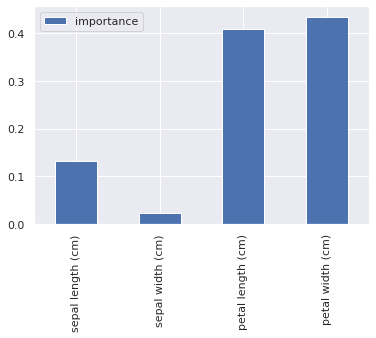

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# load data set
data = load_iris()
X = data['data']
y = data['target']
feature_names = data['feature_names']

# tune random forest
tree = RandomForestClassifier(n_estimators=20, random_state=0)
param_grid = {'max_depth': range(2, 10), 'min_samples_split': [2, 4, 6, 8, 10]}
grid_search = GridSearchCV(tree, param_grid, cv=3, n_jobs=2, verbose=1)
grid_search.fit(X, y)
best_model = grid_search.best_estimator_

# plot feature importance
df = pd.DataFrame({'importance': best_model.feature_importances_}, index=feature_names)
df.plot.bar();

## Exercises

1. For the California housing data set, tune `max_depth` and either `min_samples_split` or `min_samples_leaf` for a decision tree regressor.
1. Repeat the previous task but use a random forest, extremely randomized trees, and a gradient boosting tree. Consider the available hyperparameters for each of the models and decide which ones to include when tuning. How do the  models perform?

*Copyright &copy; 2021 WorldQuant University. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*